In [2]:
import pandas as pd
import numpy as np
from collections import Counter


In [3]:
from google.colab import drive
!cd ~
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA"
!ls

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/unsupervised_project/MSA
'family msa_gen_vector_iadf+.ipynb'   msa_gen_vector_iadf.ipynb   RE_df.gsheet
 msa_gen_vector_iadf+.ipynb	      msa.ipynb			  RE_df.tsv


In [4]:
df_data = pd.read_csv('RE_df.tsv', sep='\t')
df_data['family_lable'] =  df_data['msa'].str.split('_').str[0]
family_lables = df_data['family_lable'].to_list()
dataset = df_data['seq'].tolist()
true_lables = df_data['is_RE'].tolist()

In [5]:
def kmers_extraction(msa, kmer_size=3):
  kmers=[]
  for i,_ in enumerate(msa):
    if i < len(msa)-kmer_size+1:
      kmers.append(msa[i:i+kmer_size])
  return kmers


In [6]:
def preprocess(dataset):
 return [kmers_extraction(i) for i in dataset ]
processed_text = preprocess(dataset)

In [7]:

DF = {}
for i in range(len(processed_text)):
    tokens = processed_text[i]
    for w in tokens:
        try:
            DF[w].add(i)
        except:
            DF[w] = {i}

In [8]:
total_vocab = [x for x in DF]
# total_vocab

In [9]:
def doc_freq(word):
    c = 0
    try:
        c = DF[word]
    except:
        pass
    return len(c)

In [10]:
import math 

 # mean df for ne algo

tf_idf = {}

N = len(dataset)

def gen_vector_iadf_plus(tokens):
  doc = 0
  sum_df = 0
  for token in np.unique(tokens):
    df = doc_freq(token)
    sum_df +=df
    doc += 1
  mean_df = sum_df /  len(np.unique(tokens))

  Q = np.zeros((len(total_vocab)))

  counter = Counter(tokens)
  words_count = len(tokens)

  query_weights = {}
  
  doc = 0
  n_ = np.unique(tokens)
  for token in np.unique(tokens):
      
      tf = counter[token]/words_count
      df = doc_freq(token)
      if (df- mean_df) ==0:
        df + 0.00001
      df_ = math.log(abs(df- mean_df)/len(n_)+1)+1 # for new algo. - mean_df devide n

      idf = math.log((N+1)/(df_+1))

      try:
          ind = total_vocab.index(token)
          Q[ind] = tf*idf
      except:
          pass
  return Q


# the run

# TSNE

In [11]:
vecs = [ gen_vector_iadf_plus(i)  for i in preprocess(dataset)]
# vecs

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns
from numpy import reshape

def tsne(vecs):
  x = np.array(vecs)
  # x = reshape(x, [x.shape[0], x.shape[1]*x.shape[2]])
  tsne = TSNE(n_components=2, verbose=1)
  z = tsne.fit_transform(x)
  df = pd.DataFrame()

  df["y"] = family_lables
  df["comp-1"] = z[:,0]
  df["comp-2"] = z[:,1]
  df['color'] = true_lables
  # df = df.query('y=="Salmonella"')
  return df, z
  

In [13]:
df , z = tsne(vecs)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5490 samples in 0.001s...
[t-SNE] Computed neighbors for 5490 samples in 0.621s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5490
[t-SNE] Computed conditional probabilities for sample 2000 / 5490
[t-SNE] Computed conditional probabilities for sample 3000 / 5490
[t-SNE] Computed conditional probabilities for sample 4000 / 5490
[t-SNE] Computed conditional probabilities for sample 5000 / 5490
[t-SNE] Computed conditional probabilities for sample 5490 / 5490
[t-SNE] Mean sigma: 0.129480
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.055939
[t-SNE] KL divergence after 1000 iterations: 1.789216


# families clusters


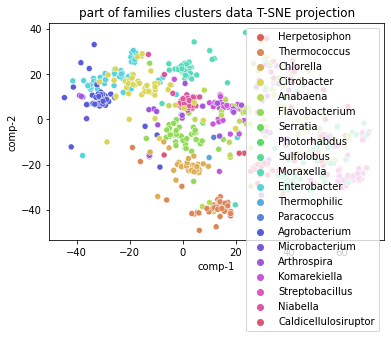

In [14]:
## families clusters
part_of_families = list(set(family_lables))[30:50]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data T-SNE projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

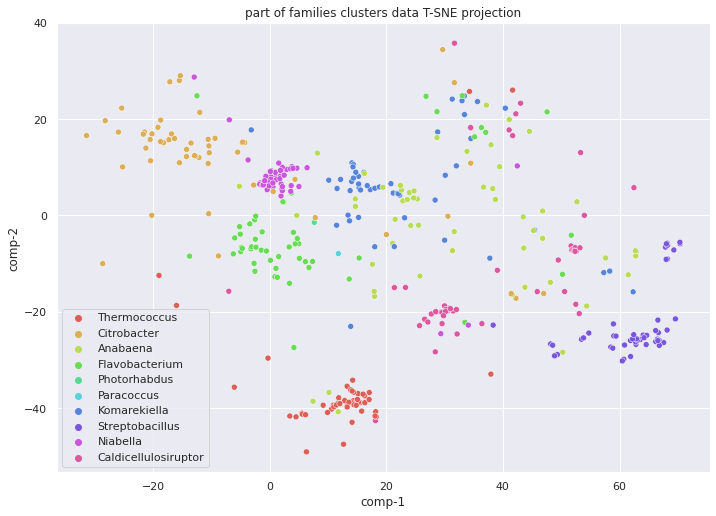

In [15]:
## families clusters
part_of_families = list(set(family_lables))[30:40]
df2= df.query('y in @part_of_families')

sns.scatterplot(x="comp-1", y="comp-2", hue=df2.y.tolist(),
                  palette=sns.color_palette("hls", len(df2.y.unique())),sizes=[600,800],
                  data=df2).set(title=f"part of families clusters data T-SNE projection")
  
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [16]:
# tsne visualizetion by family

<ipython-input-82-99f06393cdf8>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


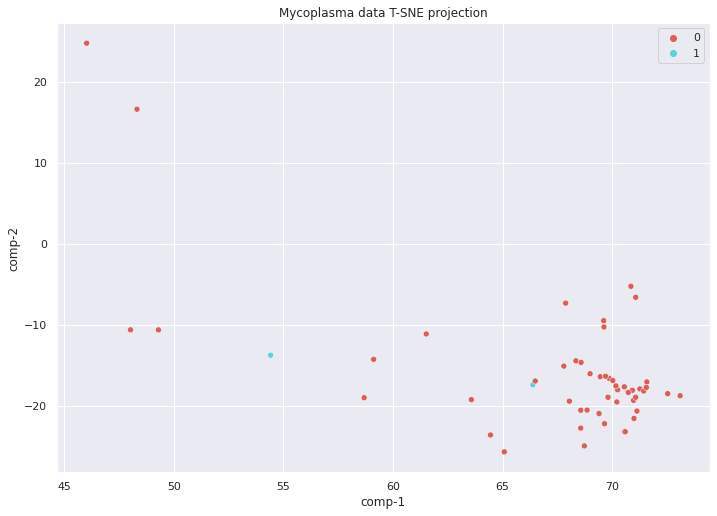

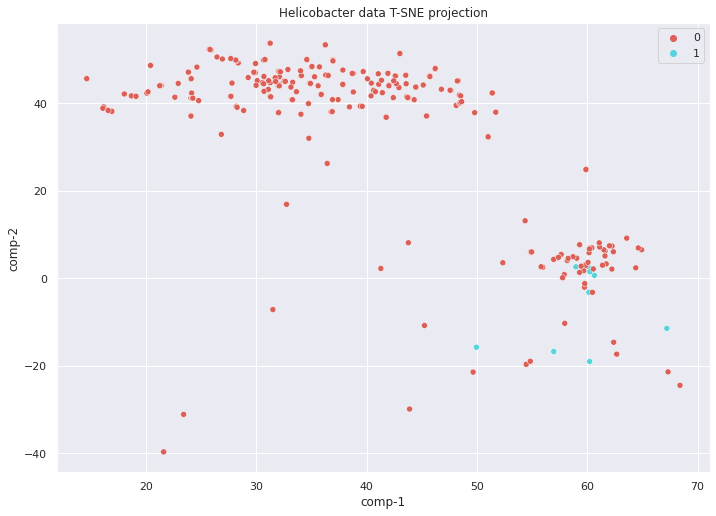

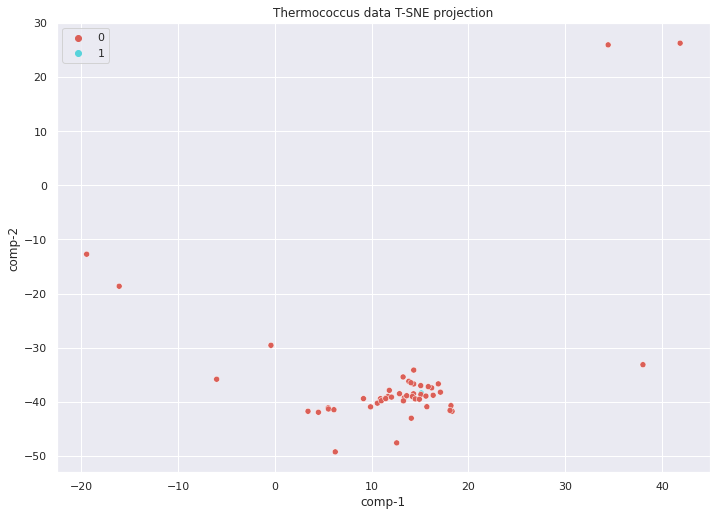

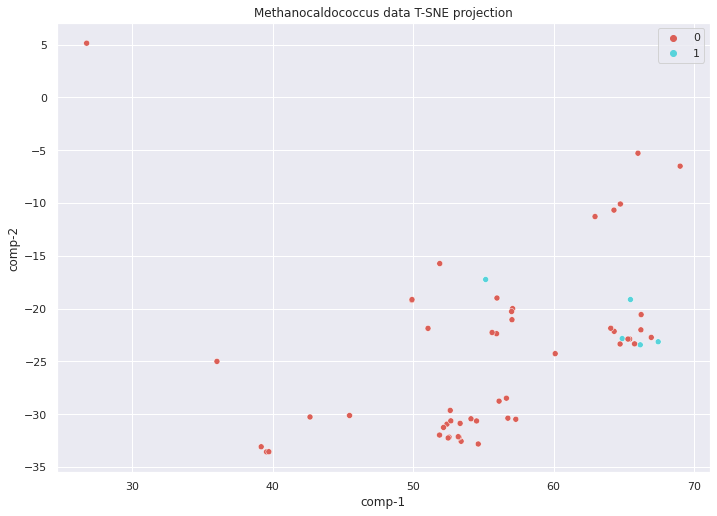

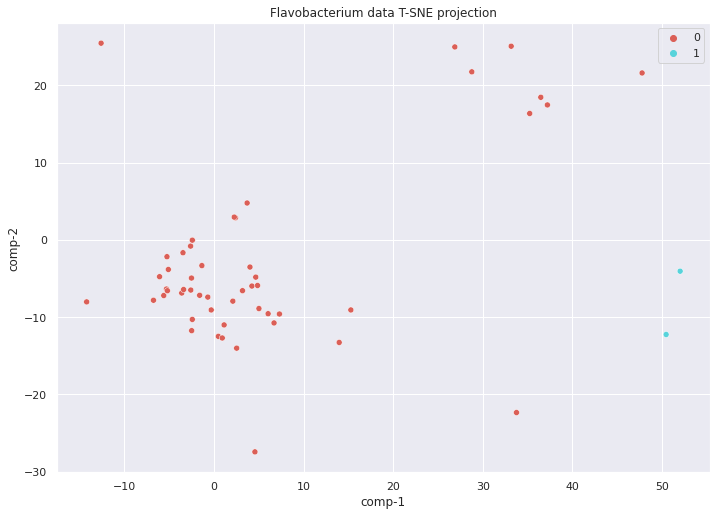

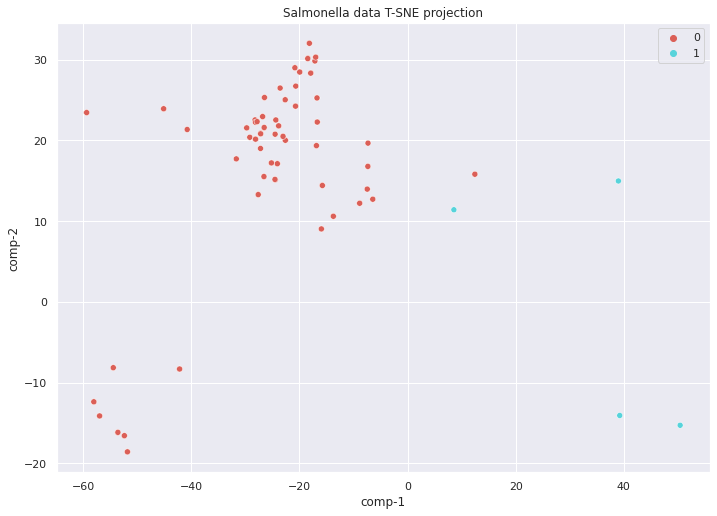

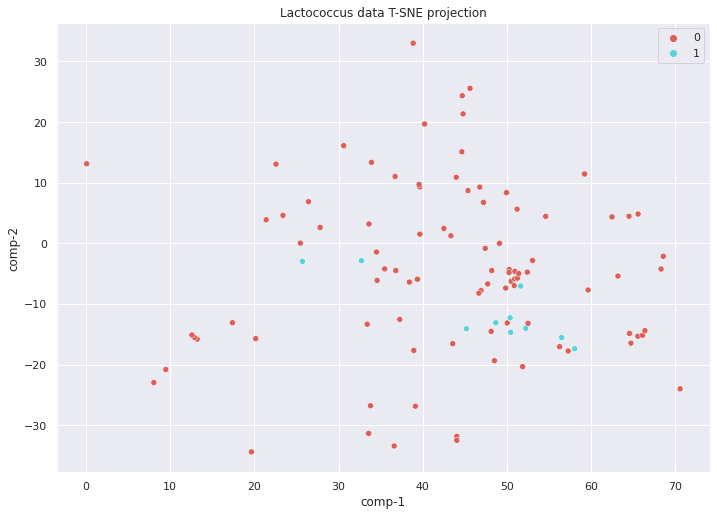

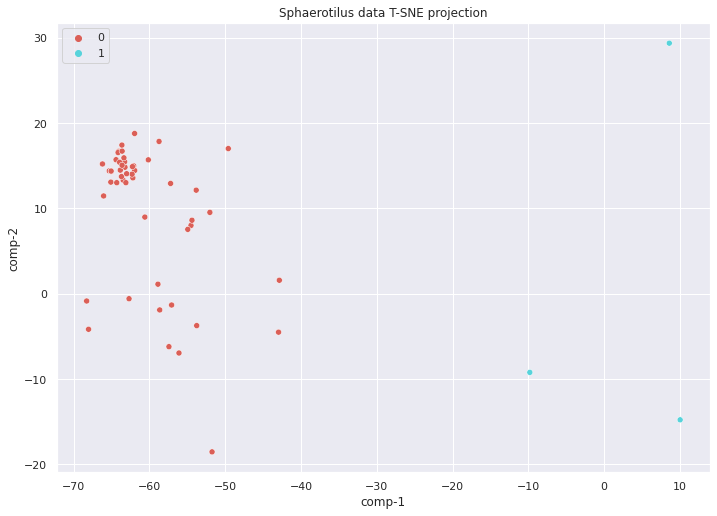

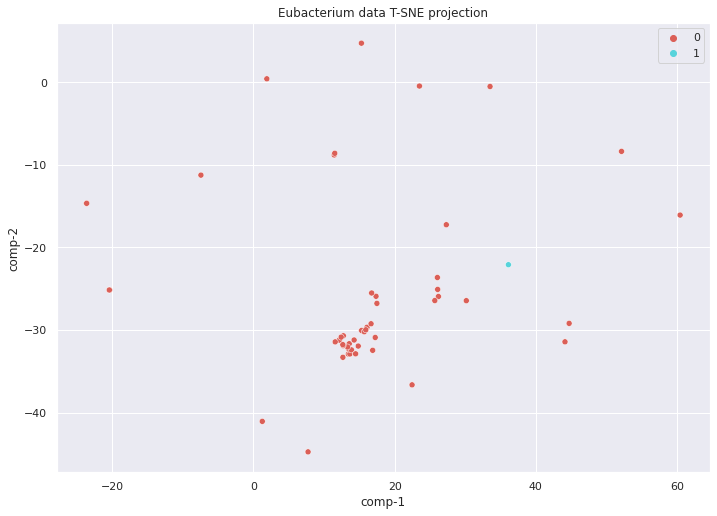

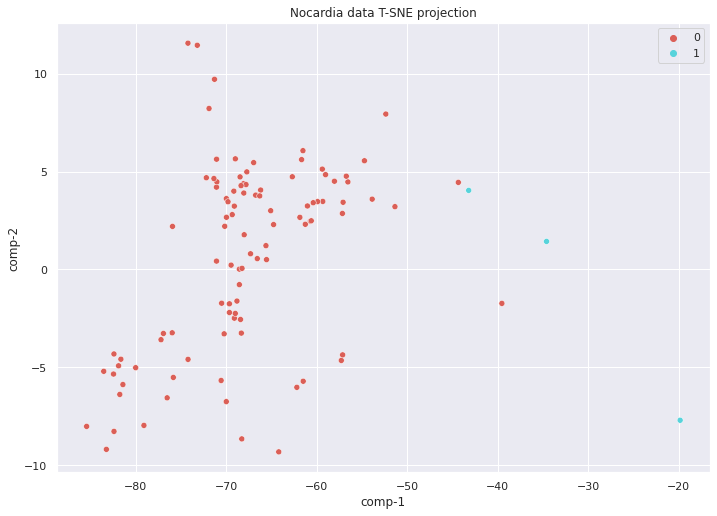

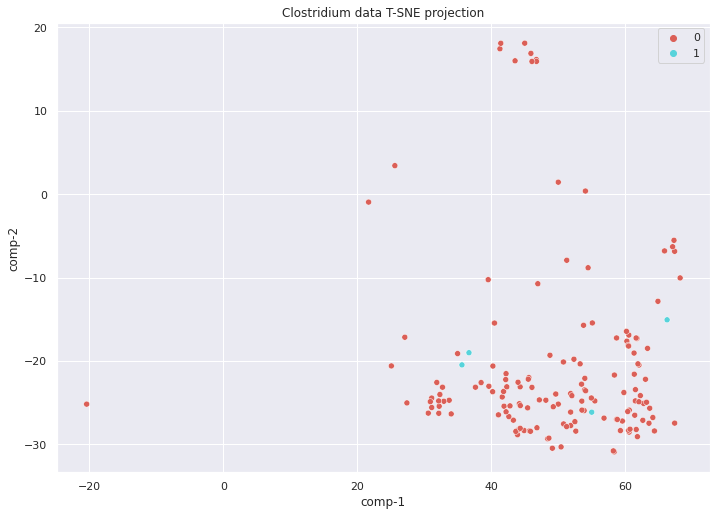

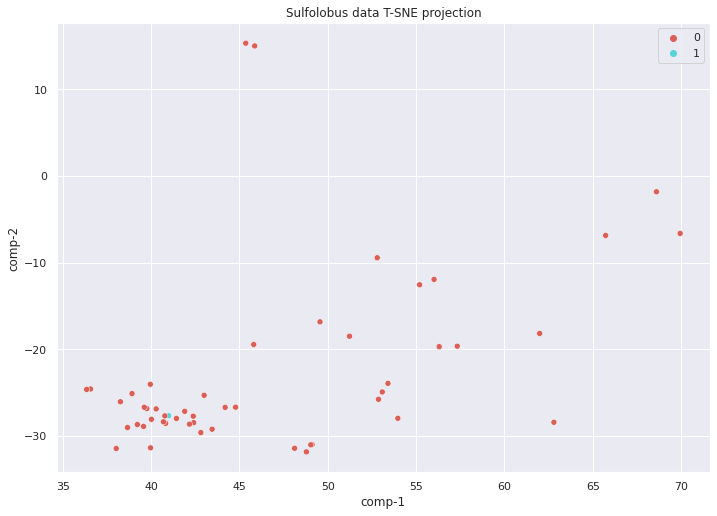

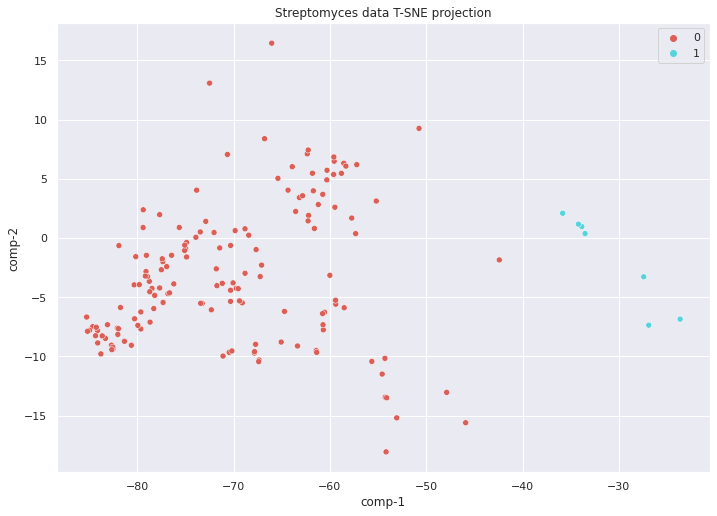

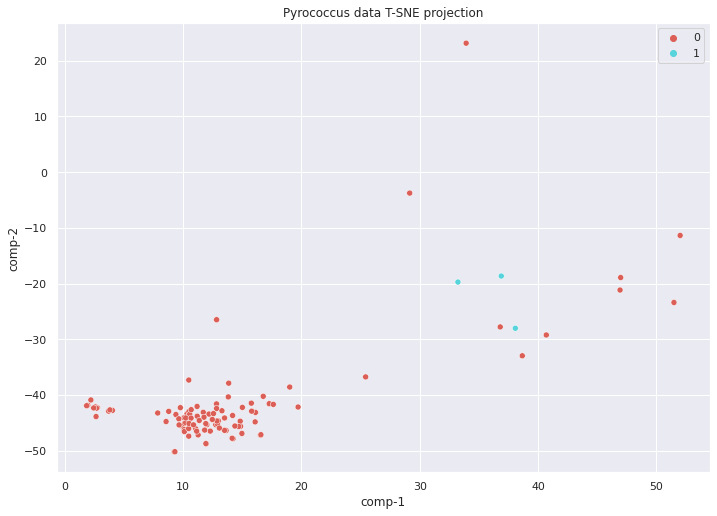

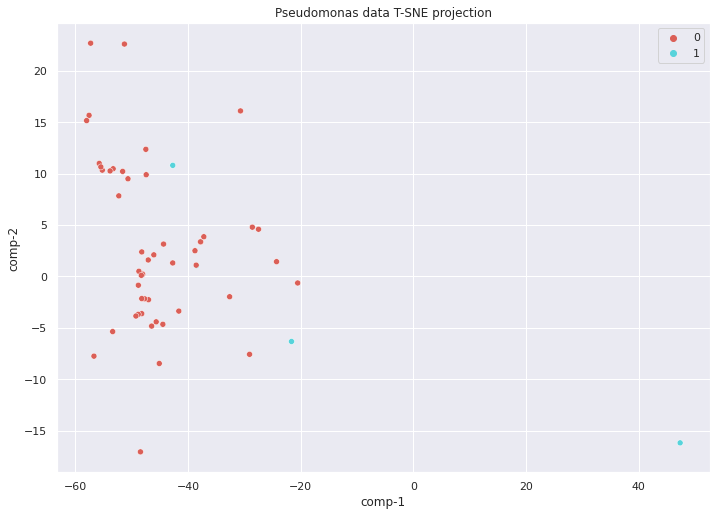

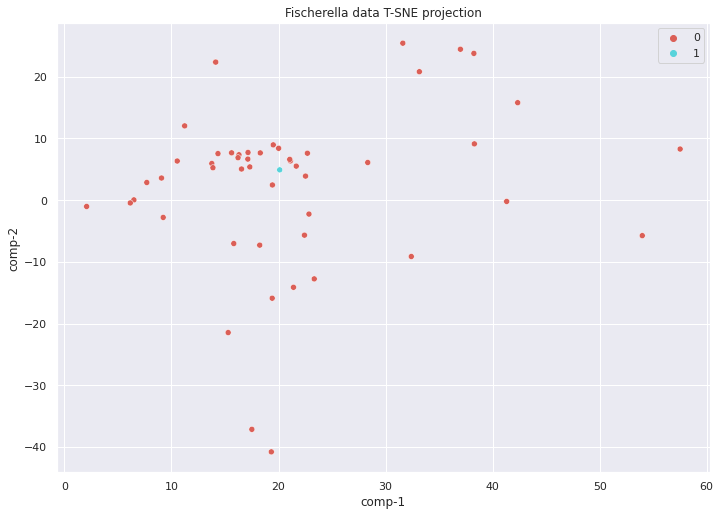

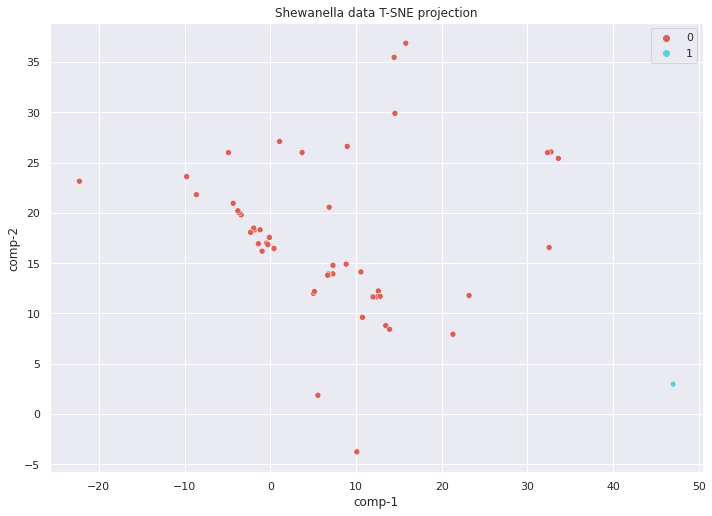

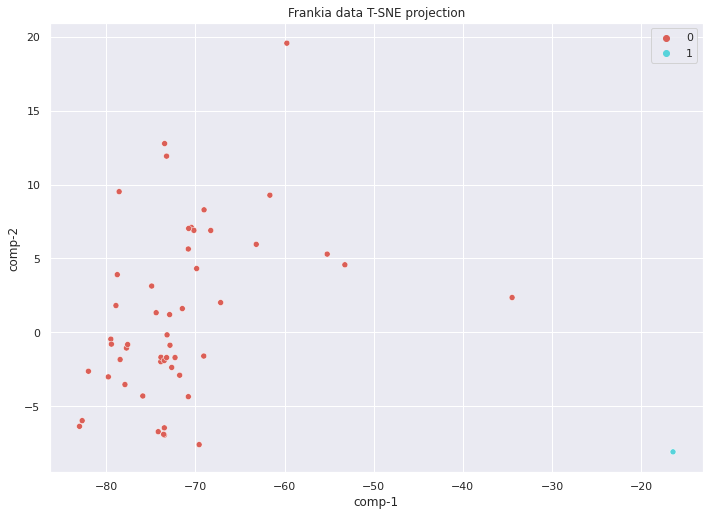

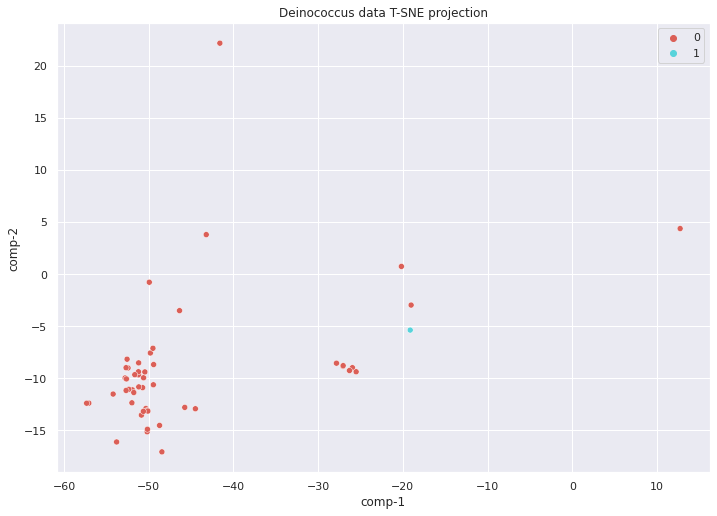

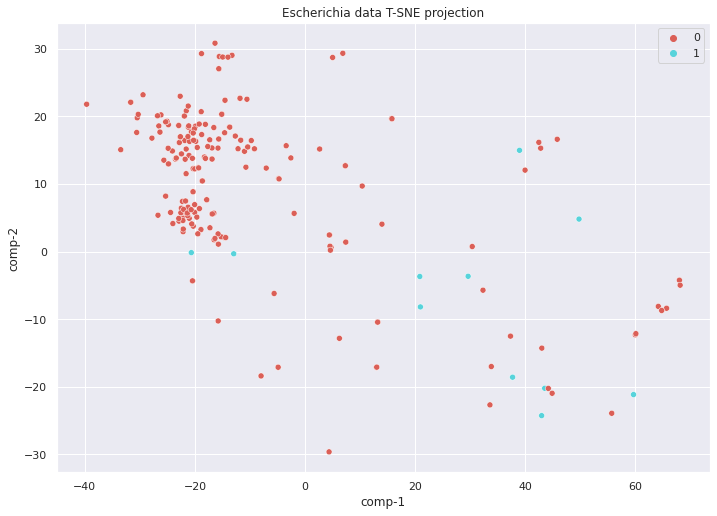

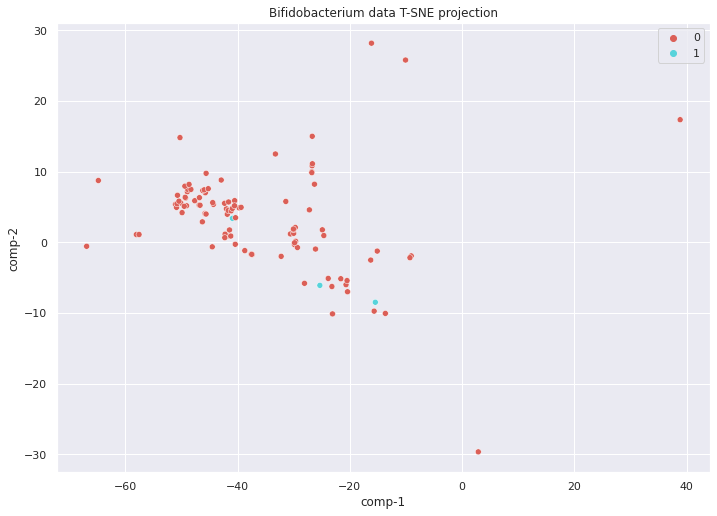

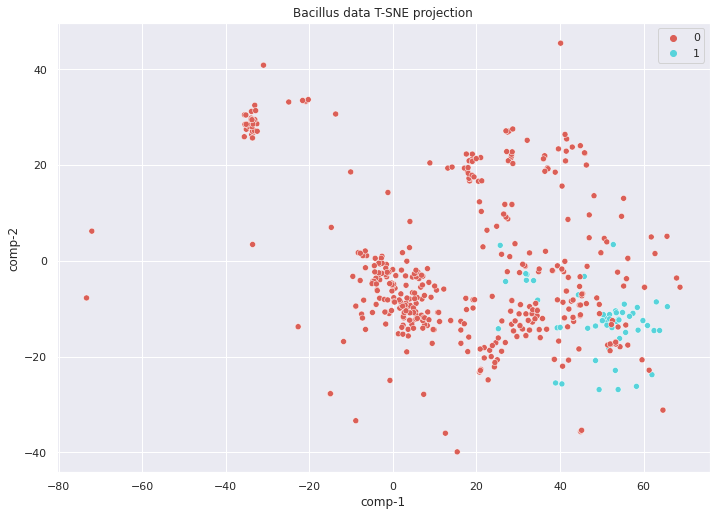

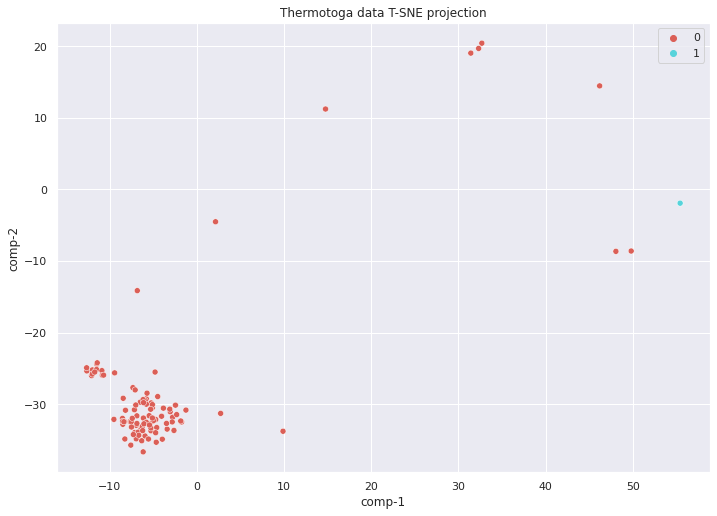

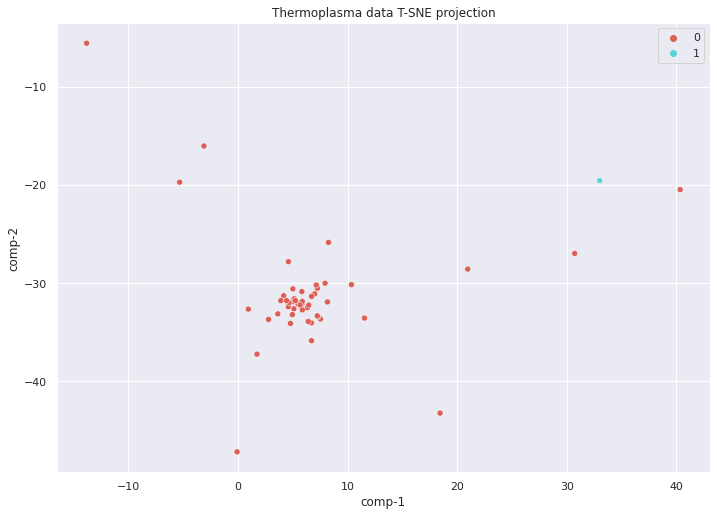

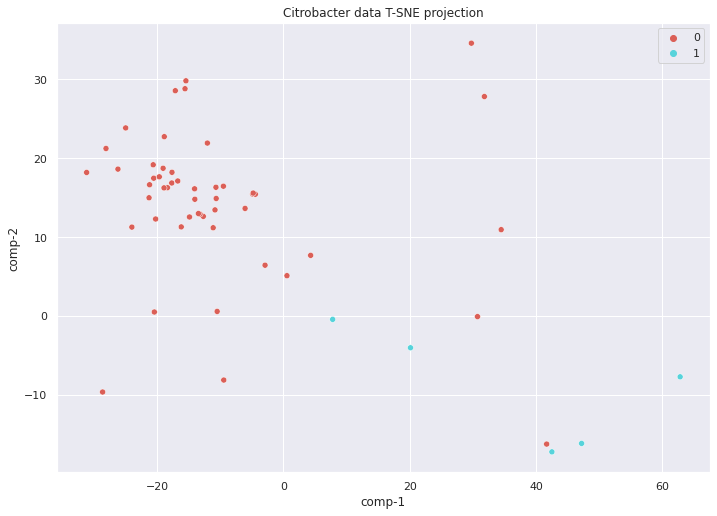

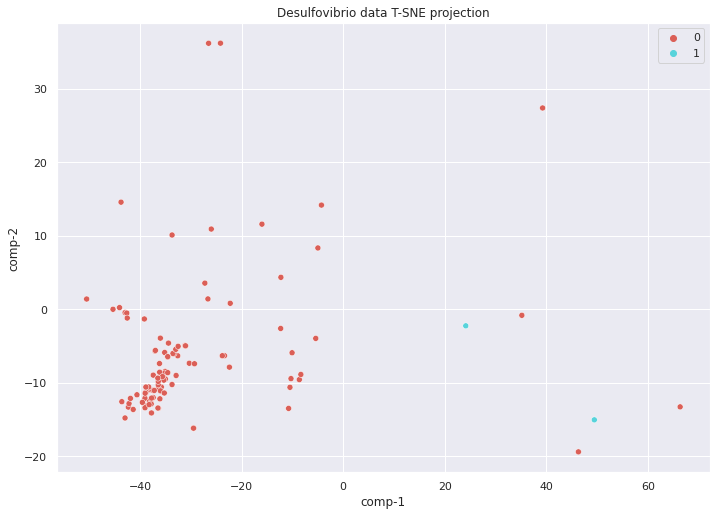

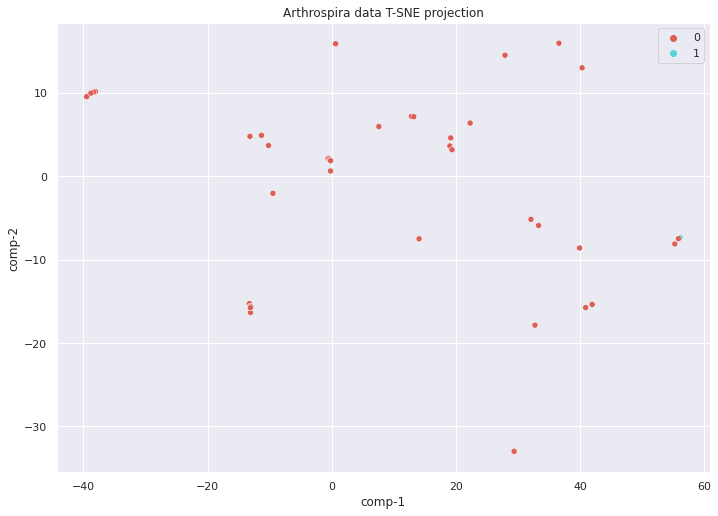

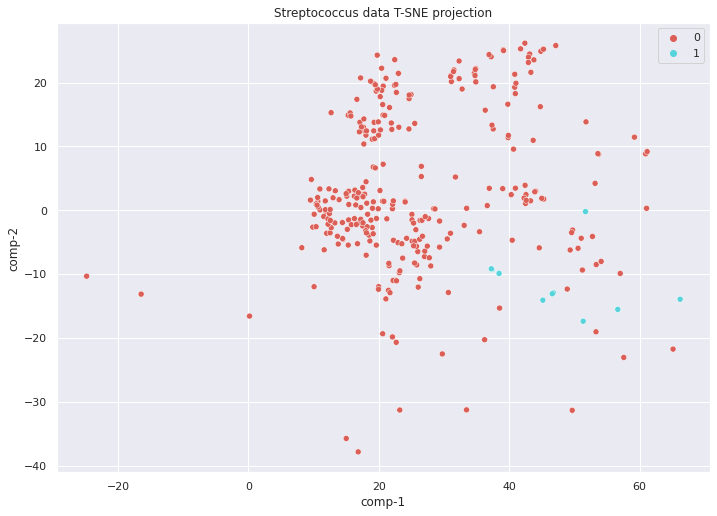

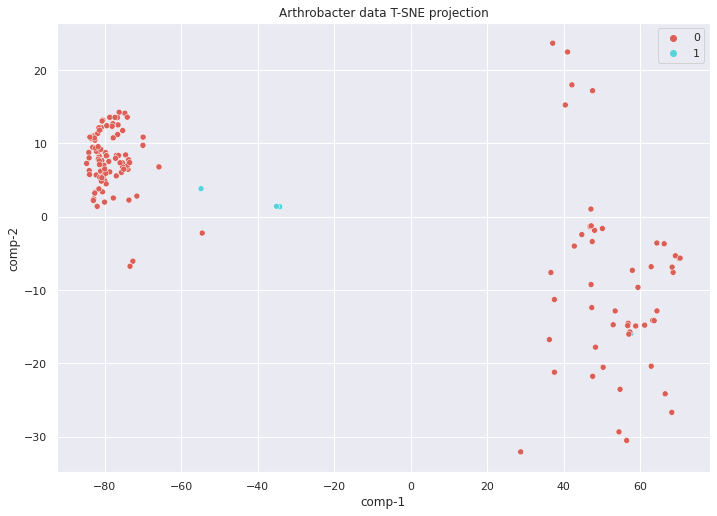

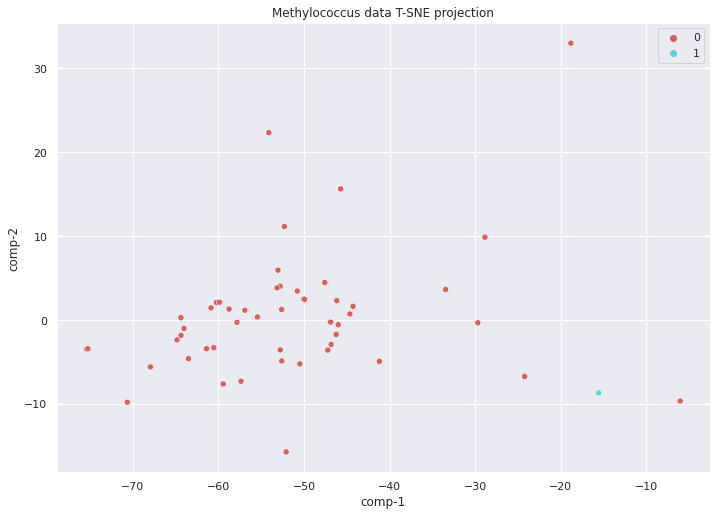

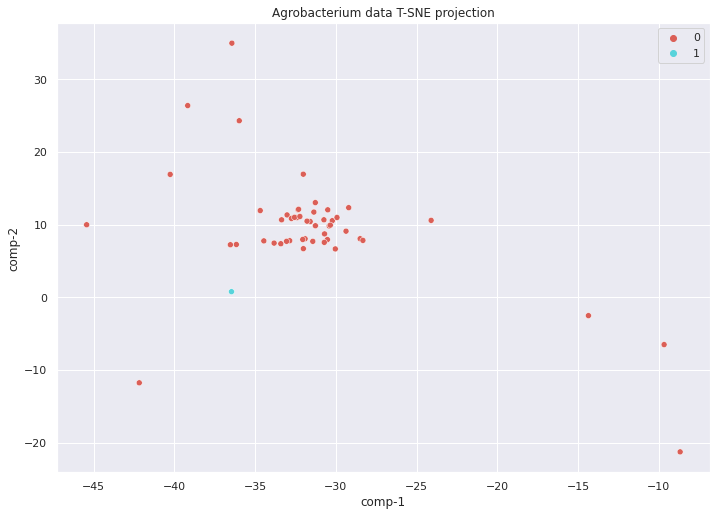

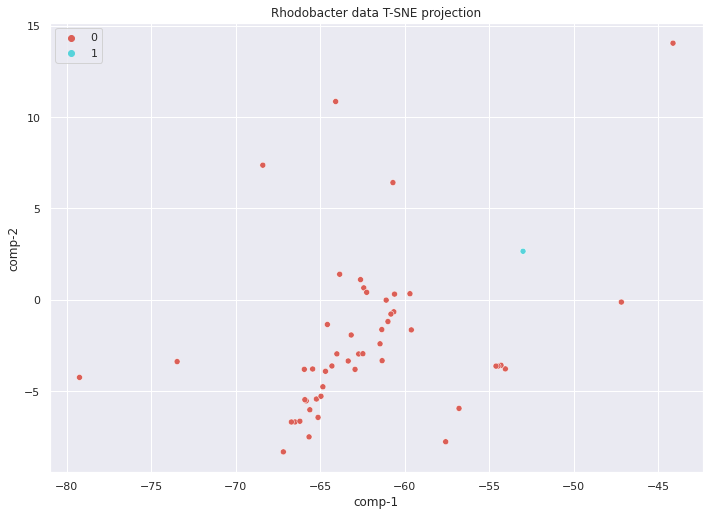

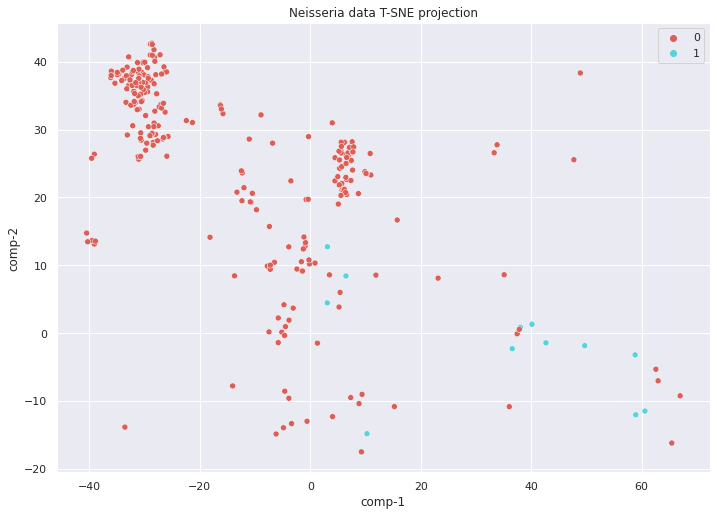

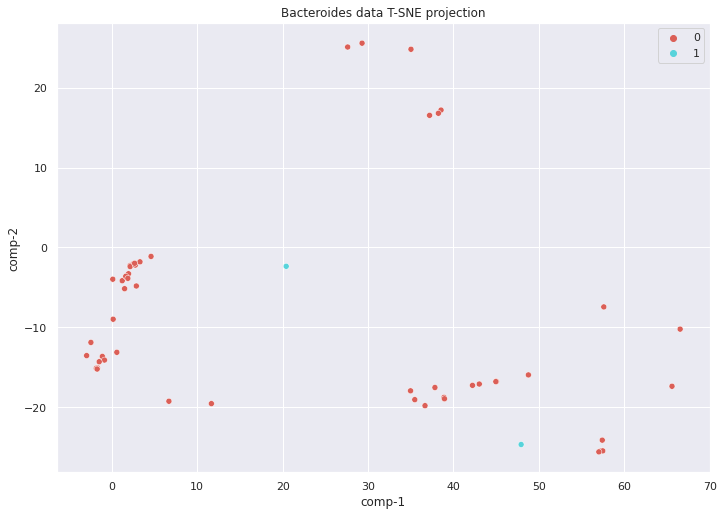

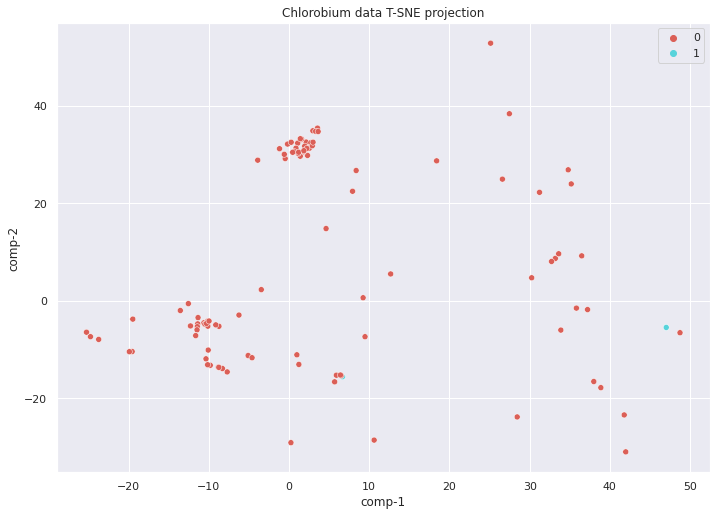

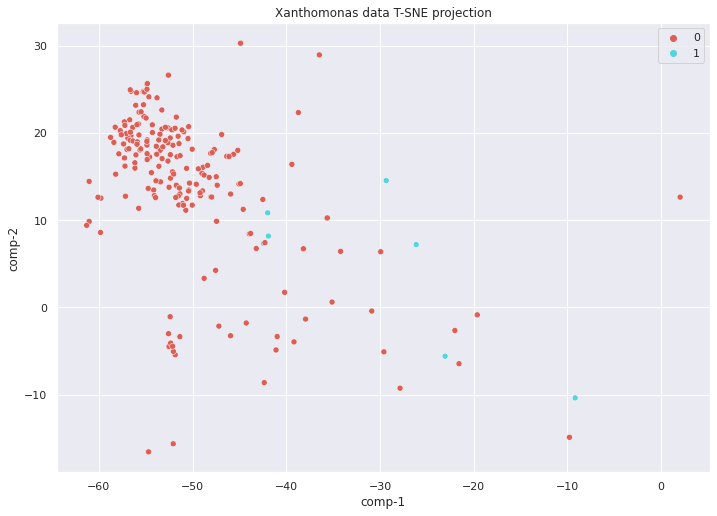

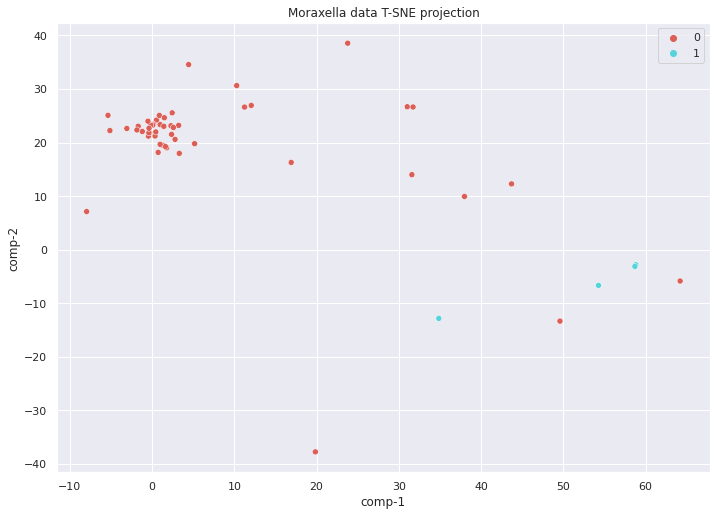

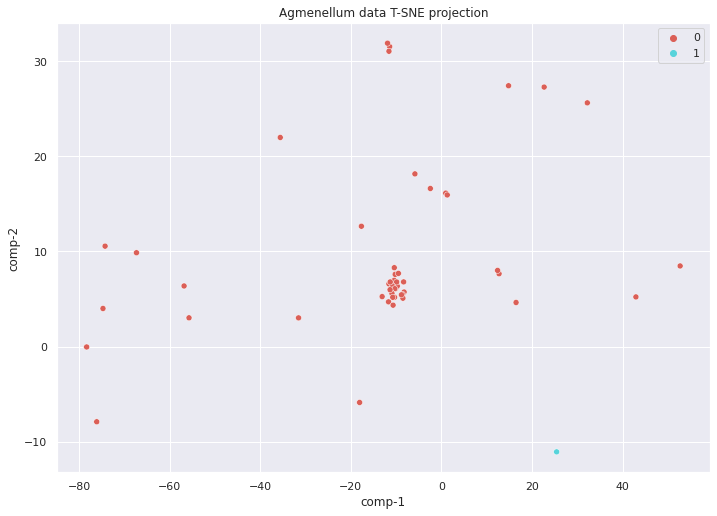

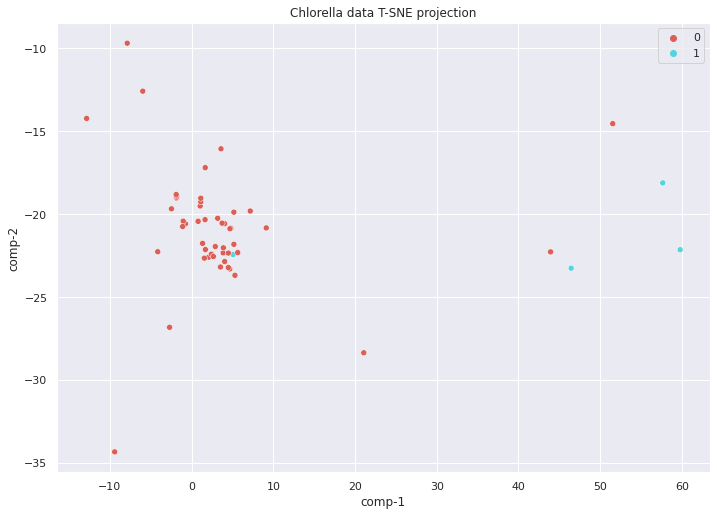

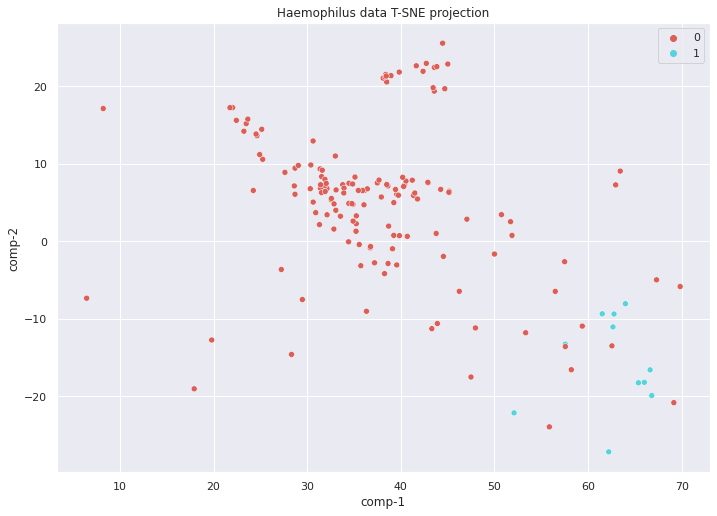

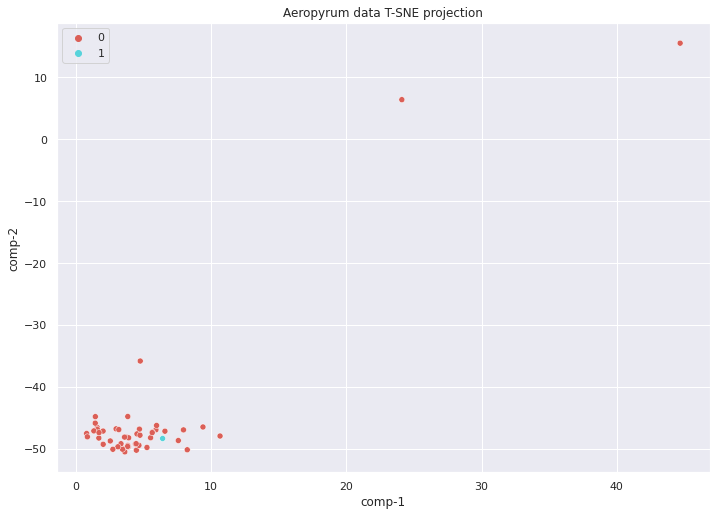

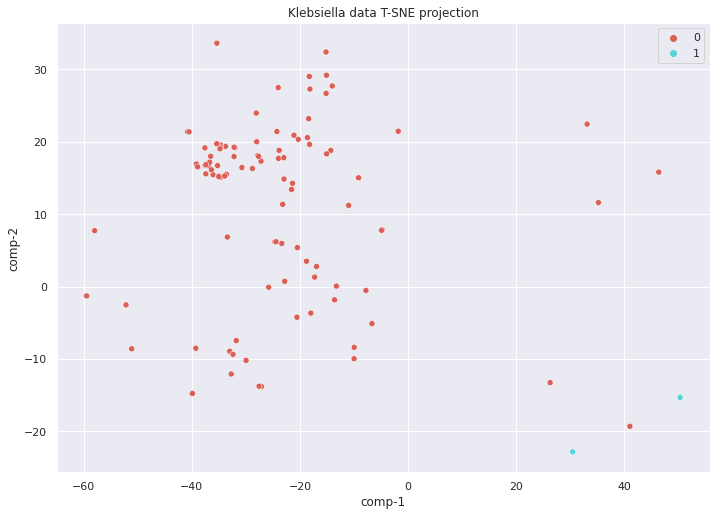

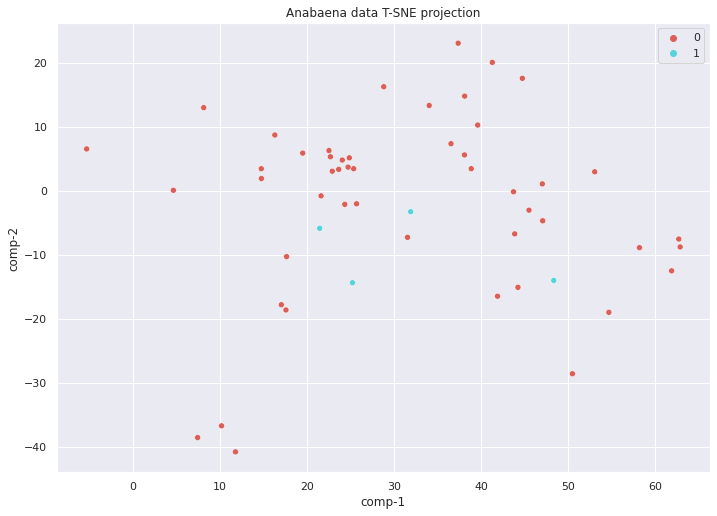

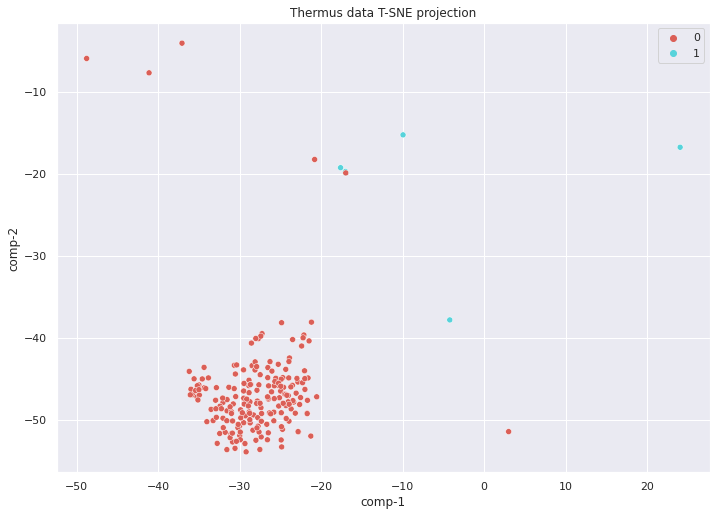

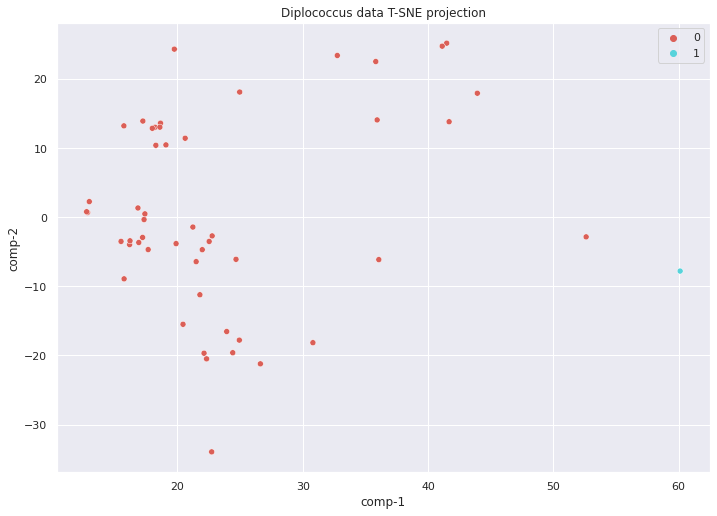

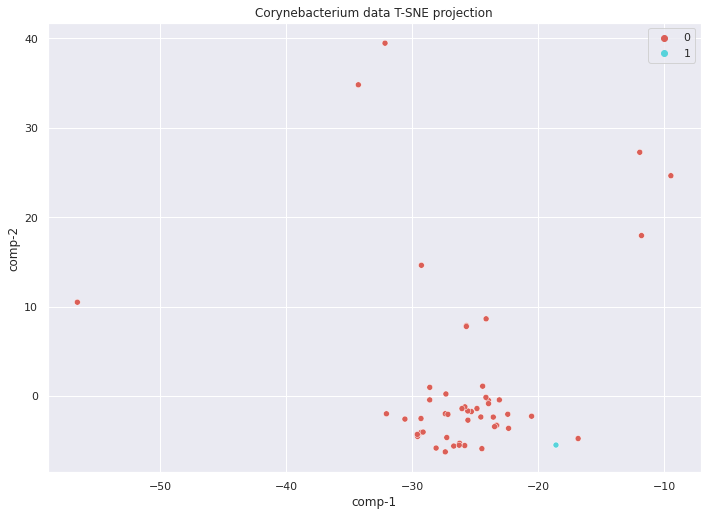

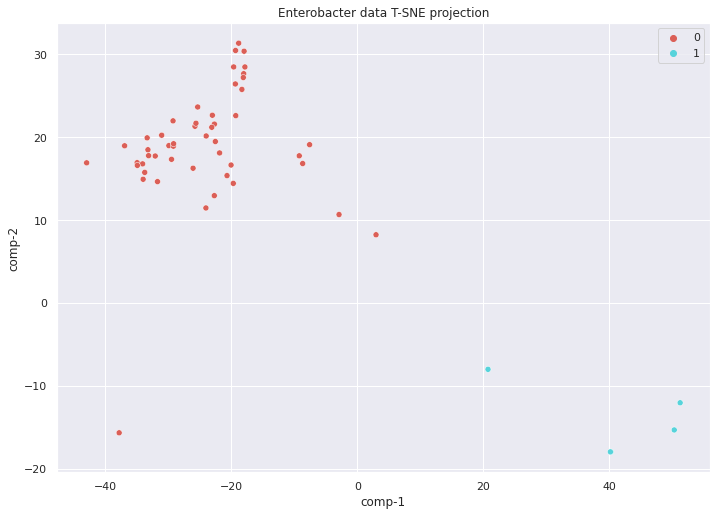

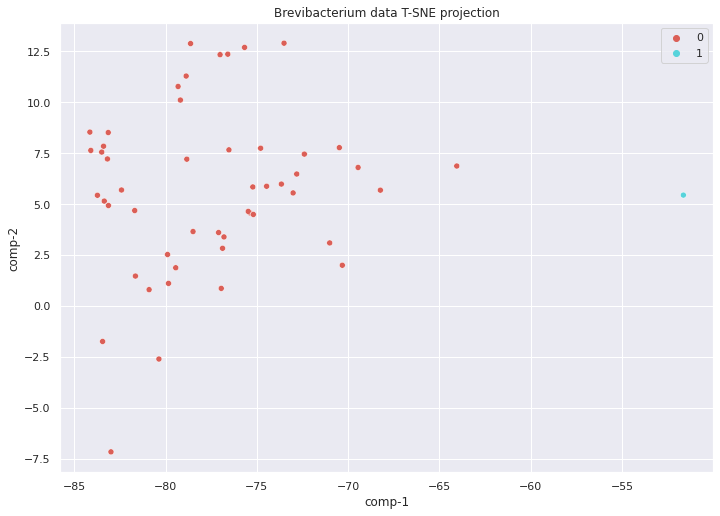

In [ ]:
import matplotlib.pyplot as plt

for i in set(family_lables):
  df1= df.query('y==@i') ### very bad example: Thermococcus - maybe good
  if len(df1.color.unique())>1:
    plt.figure()
    sns.scatterplot(x="comp-1", y="comp-2", hue=df1.color.tolist(),
                      palette=sns.color_palette("hls", 2),sizes=[600,800],
                      data=df1).set(title=f"{i} data T-SNE projection")
      
    sns.set(rc={'figure.figsize':(11.7,8.27)})


# general function

In [122]:
def confusion_matrix_re(true_lables, pred_lables):
  tp = 0
  fp = 0
  fn = 0
  tn = 0
  sum = 0
  for true, pred in zip(true_lables, pred_lables):
    if true == 1 and  pred == -1:
      tp +=1
    if true == 1 and  pred != -1:
      fp = 0
    if true == 0 and  pred == -1:
      fn +=1
    if true == 0 and  pred != -1:
      tn +=1
    return tp/len(true_lables) , fp/len(true_lables), fn/len(true_lables),  tn/len(true_lables)



In [123]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import fowlkes_mallows_score
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score 
from sklearn.metrics import homogeneity_completeness_v_measure


all_res_table= []


def clustering_function(familyes,df_data, df, algorithem, params):
  familyes =  sorted(familyes)
  for ind, i  in enumerate(familyes):
    d = {}
    d['algo'] = algorithem
    df1= df.query('y==@i')
    df_data1 = df_data.query('family_lable==@i')
   
    true_labels = df_data1.is_RE.tolist()

    if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
      print('-------------------')
      print(i)
      d['family_lable'] = i 
      print (ind ,i)
      if params:
        algo = algorithem(**params[ind-1])
      else:
        algo = algorithem()
      pred_labels = algo.fit_predict(df1[['comp-1','comp-2']].values)
      if len(set(pred_labels))>1:
        ari = adjusted_rand_score(true_labels, pred_labels)
        print(f"Adjusted Rand Index: {ari}")

        d['ari'] = ari 

        fmi = fowlkes_mallows_score(true_labels, pred_labels)
        print(f"fowlkes_mallows_score: {fmi}")

        d['fmi'] = fmi 

        homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(true_labels, pred_labels)
        print(f"homogeneity_completeness_v_measure: {homogeneity} {completeness} {v_measure}")


        d['homogeneity'] = homogeneity 
        d['completeness'] = completeness 
        d['v_measure'] = v_measure 

        tp, fp, fn, tn = confusion_matrix_re(true_lables, pred_labels)
        d['tp'] = tp
        d['fp'] = tp
        d['fn'] = tp
        d['tn'] = tp


        all_res_table.append(d)
      else:
        print('caoudnot seperate to clusters')

      markers = ["." if label == 0 else "d" for label in true_labels]
      if -1 in pred_labels:
        colors = ["red" if label == -1 else "black" for label in pred_labels]
      else:
        colors = ["blue" if label == 1 else  "orange" for label in pred_labels]

    

      for i in range(len(markers)):
        plt.scatter(df1['comp-1'].values[i], df1['comp-2'].values[i], c=colors[i] ,marker=markers[i])
      plt.show()





# dbscan

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

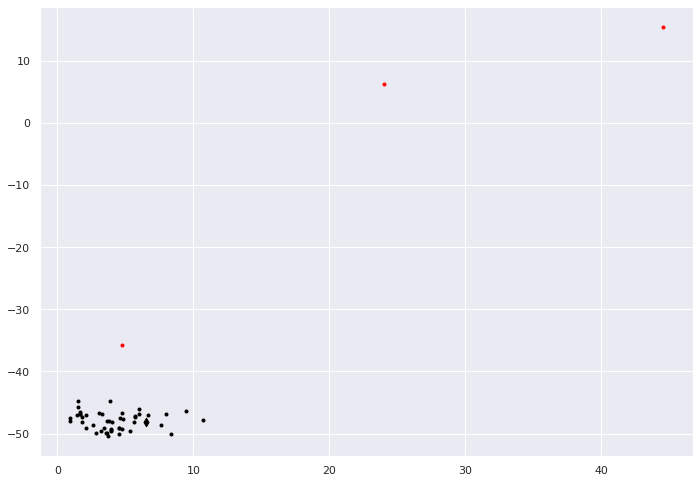

-------------------
Agmenellum
5 Agmenellum
Adjusted Rand Index: -0.004362843119432831
fowlkes_mallows_score: 0.6857608019462199
homogeneity_completeness_v_measure: 0.13101934947788751 0.01828789011963489 0.03209579754145304


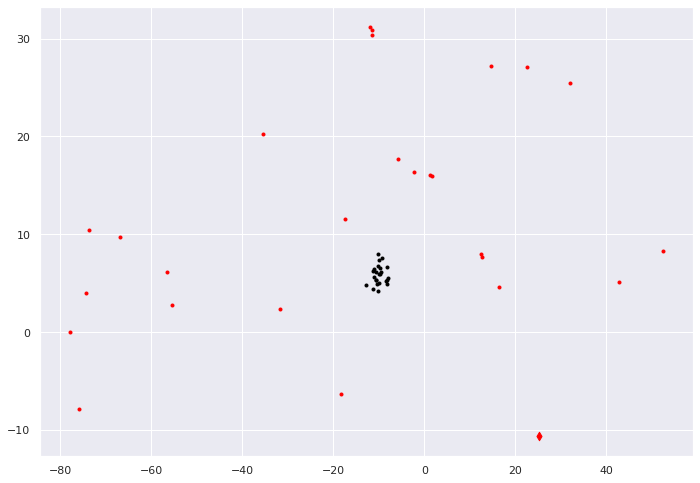

-------------------
Agrobacterium
6 Agrobacterium
Adjusted Rand Index: -0.028976175144880875
fowlkes_mallows_score: 0.9209370289426528
homogeneity_completeness_v_measure: 0.012443374527241603 0.005367903947640151 0.007500285770158736


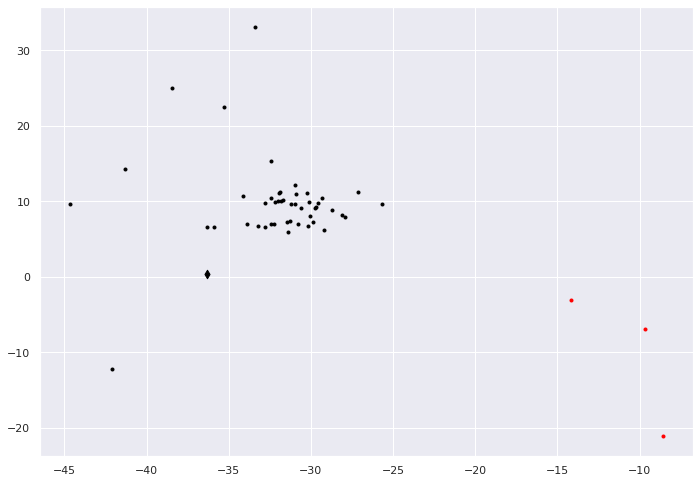

-------------------
Anabaena
7 Anabaena
Adjusted Rand Index: -0.010273225581738989
fowlkes_mallows_score: 0.5243618886883005
homogeneity_completeness_v_measure: 0.0964664491260628 0.023383767092280083 0.03764280198666674


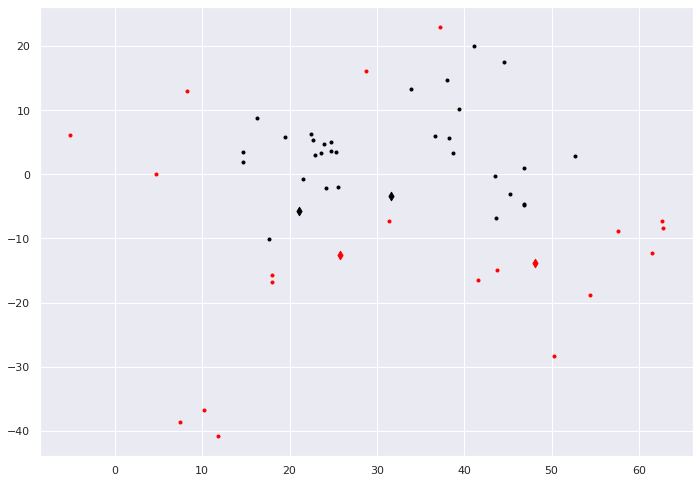

-------------------
Arthrobacter
9 Arthrobacter
Adjusted Rand Index: 0.08216075294885129
fowlkes_mallows_score: 0.7151536983054532
homogeneity_completeness_v_measure: 0.5185168927839332 0.07100083628369891 0.12489915468059046


KeyboardInterrupt: ignored

In [124]:
from sklearn.cluster import DBSCAN

from sklearn.cluster import KMeans

# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
  if len(df1.color.unique())> 1 and  len(set(true_labels))> 1:
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(df1[['comp-1','comp-2']])
    distances, indices = nbrs.kneighbors(df1[['comp-1','comp-2']])
    distances = np.sort(distances[:,1], axis=0)
  values.append({'eps':np.round(np.quantile(distances,0.95),5)})
# print(len(familyes))
clustering_function(familyes,df_data, df, DBSCAN, params = values)

# kmeans

In [113]:

# from sklearn.cluster import KMeans

# # params for dbscan
# values = []
# familyes = sorted(set(family_lables))
# print(familyes)
# for i in familyes:    
#   df1= df.query('y==@i')
#   df_data1 = df_data.query('family_lable==@i')
#   true_labels = df_data1.is_RE.tolist()
# # print(len(familyes))
#   values.append({'n_clusters':2})
# clustering_function(familyes,df_data, df, KMeans, params=values)

# IsolationForest

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

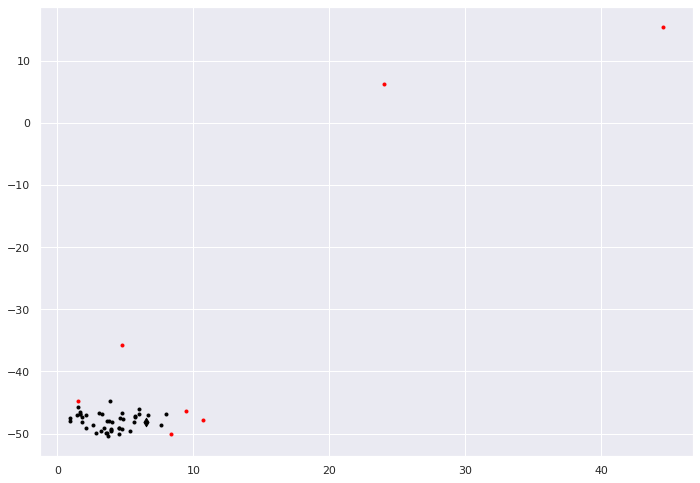

-------------------
Agmenellum
5 Agmenellum
Adjusted Rand Index: 0.04606858330446831
fowlkes_mallows_score: 0.7479575920067657
homogeneity_completeness_v_measure: 0.24000422165857632 0.03723589815953225 0.06446954907824871


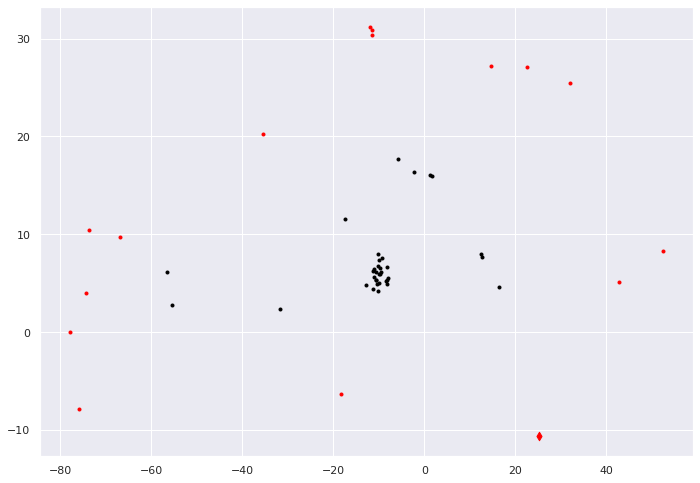

-------------------
Agrobacterium
6 Agrobacterium
Adjusted Rand Index: 0.11649862511457379
fowlkes_mallows_score: 0.8315678045512104
homogeneity_completeness_v_measure: 0.33952496221652345 0.06620737684281167 0.11080732274448242


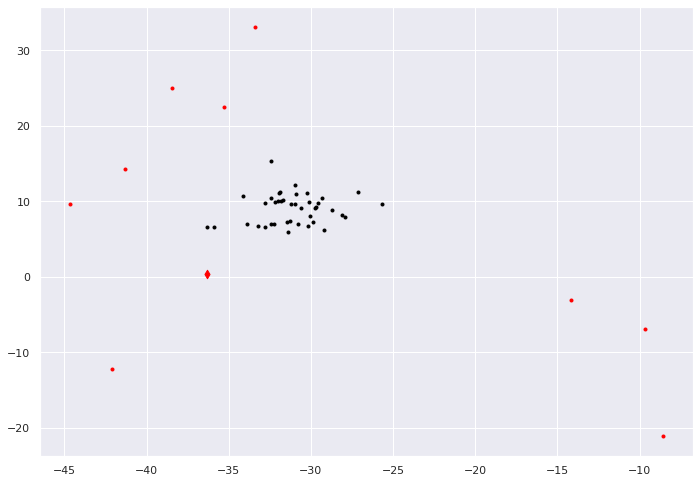

-------------------
Anabaena
7 Anabaena
Adjusted Rand Index: -0.06574900771919986
fowlkes_mallows_score: 0.6825395047309912
homogeneity_completeness_v_measure: 0.10323245263598924 0.04485607357718154 0.06253830204680641


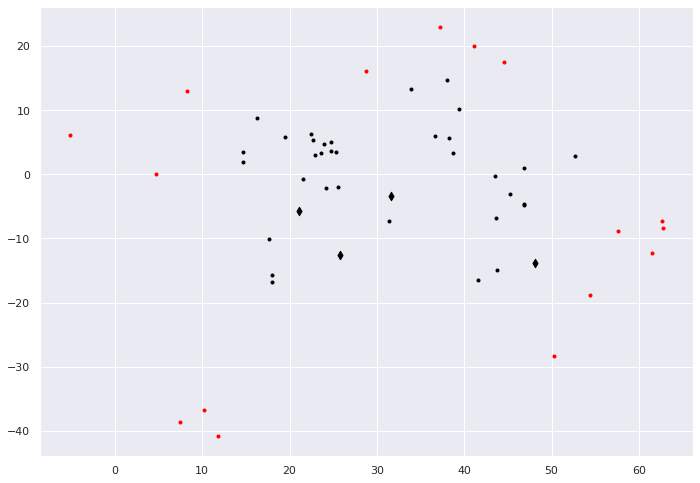

-------------------
Arthrobacter
9 Arthrobacter
Adjusted Rand Index: 0.0464264210639579
fowlkes_mallows_score: 0.7575139125320248
homogeneity_completeness_v_measure: 0.09927809259589669 0.01979525738815827 0.03300882012985019


KeyboardInterrupt: ignored

In [125]:
from sklearn.ensemble import IsolationForest


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, IsolationForest, params=None)

# one class svm 

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

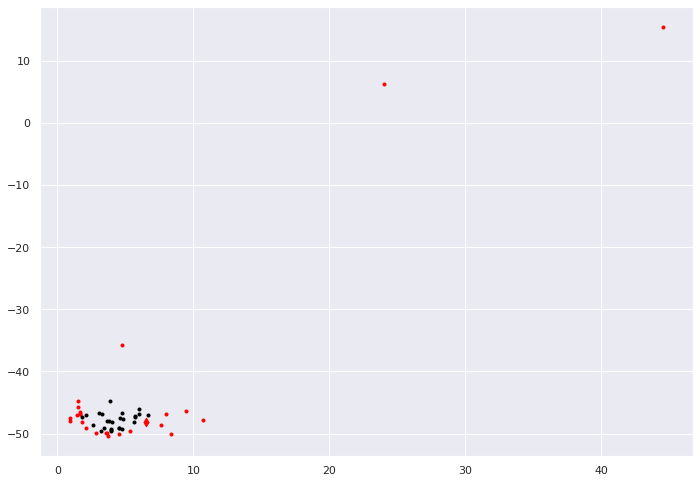

-------------------
Agmenellum
5 Agmenellum
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


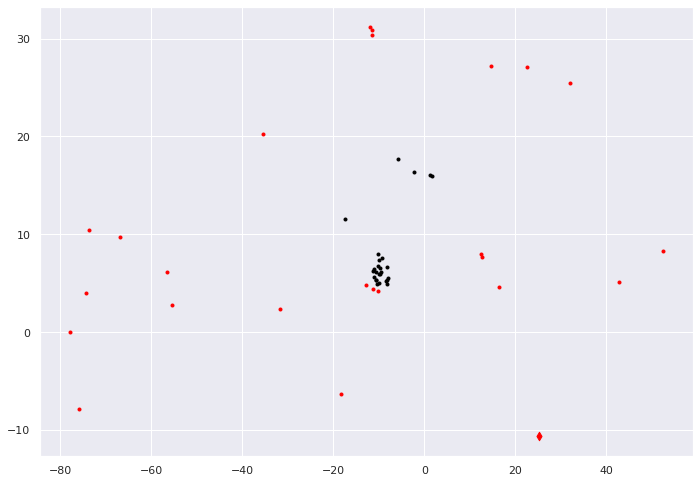

-------------------
Agrobacterium
6 Agrobacterium
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


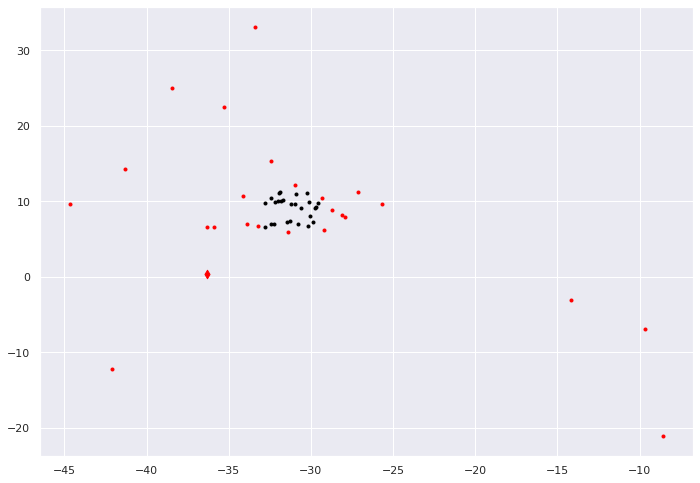

-------------------
Anabaena
7 Anabaena
Adjusted Rand Index: -0.0048226797123368005
fowlkes_mallows_score: 0.6482023827903773
homogeneity_completeness_v_measure: 0.03409840002802822 0.013002538059238813 0.01882619591576429


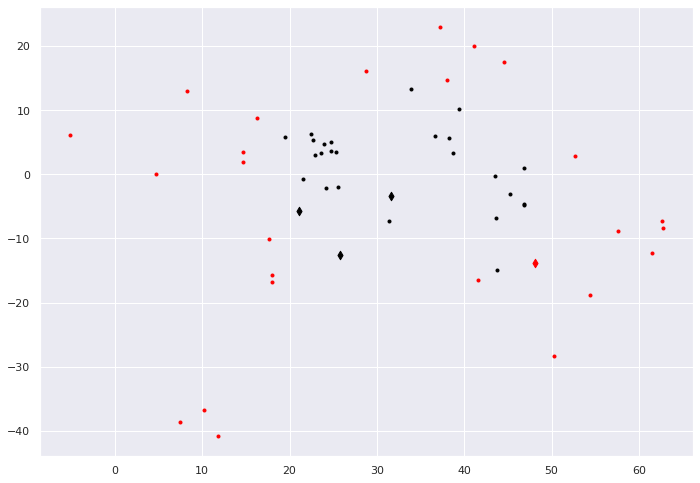

-------------------
Arthrobacter
9 Arthrobacter
Adjusted Rand Index: 0.0007056318499933976
fowlkes_mallows_score: 0.6869273544982754
homogeneity_completeness_v_measure: 0.14948252341110957 0.025980431615227492 0.04426712723003031


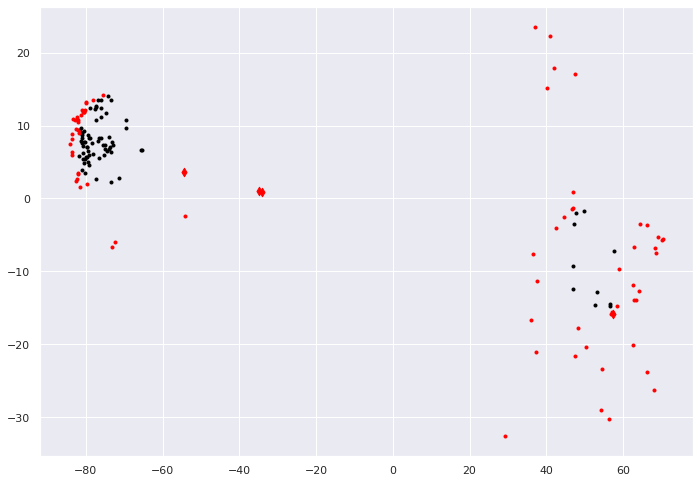

-------------------
Arthrospira
10 Arthrospira
Adjusted Rand Index: 0.0015709969788519637
fowlkes_mallows_score: 0.6868571428571428
homogeneity_completeness_v_measure: 0.1469645721288326 0.020467994981118183 0.03593172077161986


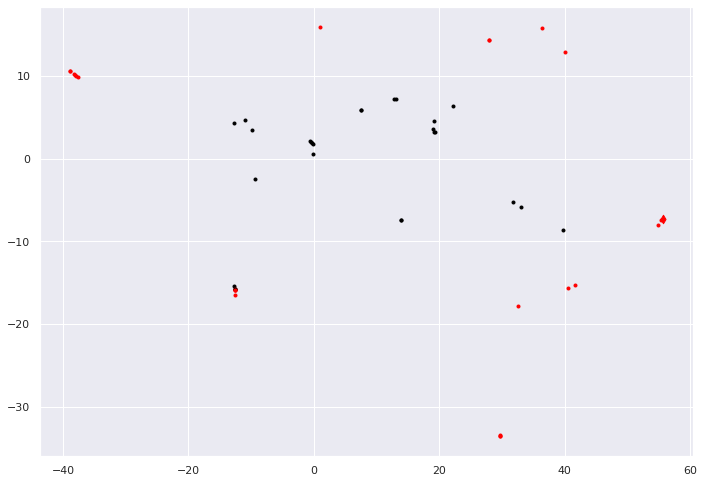

-------------------
Bacillus
11 Bacillus
Adjusted Rand Index: 0.002572352849810263
fowlkes_mallows_score: 0.6372043114391595
homogeneity_completeness_v_measure: 0.01398563424294497 0.006794013004340311 0.00914535071647367


KeyboardInterrupt: ignored

In [119]:
from sklearn.svm import OneClassSVM



# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, OneClassSVM, params=None)



# robust covarience

['Acetobacter', 'Acidocella', 'Acinetobacter', 'Aeromonas', 'Aeropyrum', 'Agmenellum', 'Agrobacterium', 'Anabaena', 'Aquaspirillum', 'Arthrobacter', 'Arthrospira', 'Bacillus', 'Bacteroides', 'Bifidobacterium', 'Brevibacterium', 'Caldicellulosiruptor', 'Caryophanon', 'Chlorella', 'Chlorobium', 'Citrobacter', 'Clostridium', 'Corynebacterium', 'Cyanothece', 'Deinococcus', 'Desulfovibrio', 'Diplococcus', 'Enterobacter', 'Environmental', 'Erwinia', 'Escherichia', 'Eubacterium', 'Fischerella', 'Flavobacterium', 'Frankia', 'Fusobacterium', 'Haemophilus', 'Helicobacter', 'Herpetosiphon', 'Klebsiella', 'Kluyvera', 'Komarekiella', 'Lactococcus', 'Listeria', 'Methanobacterium', 'Methanocaldococcus', 'Methylococcus', 'Methylophilus', 'Microbacterium', 'Micrococcus', 'Moraxella', 'Mycoplasma', 'Neisseria', 'Niabella', 'Nocardia', 'Nostoc', 'Paracoccus', 'Photorhabdus', 'Proteus', 'Providencia', 'Pseudomonas', 'Pyrococcus', 'Rhodobacter', 'Salmonella', 'Serratia', 'Shewanella', 'Shigella', 'Sphaerot

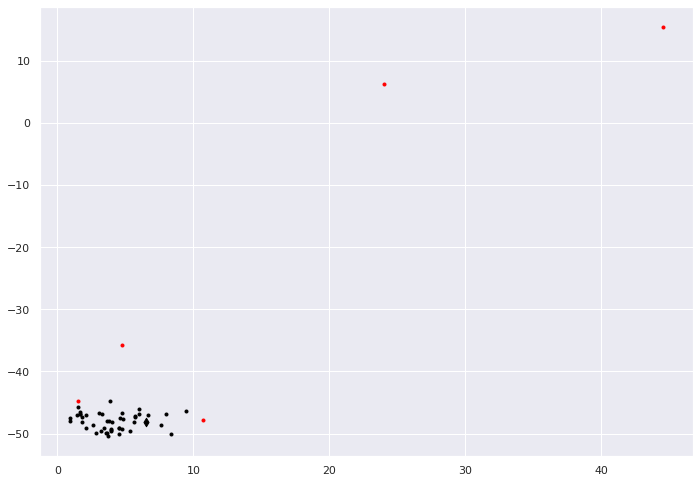

-------------------
Agmenellum
5 Agmenellum
Adjusted Rand Index: -0.030708661417322834
fowlkes_mallows_score: 0.8661085232276111
homogeneity_completeness_v_measure: 0.025698893821255796 0.006847325363367009 0.010813464167653667


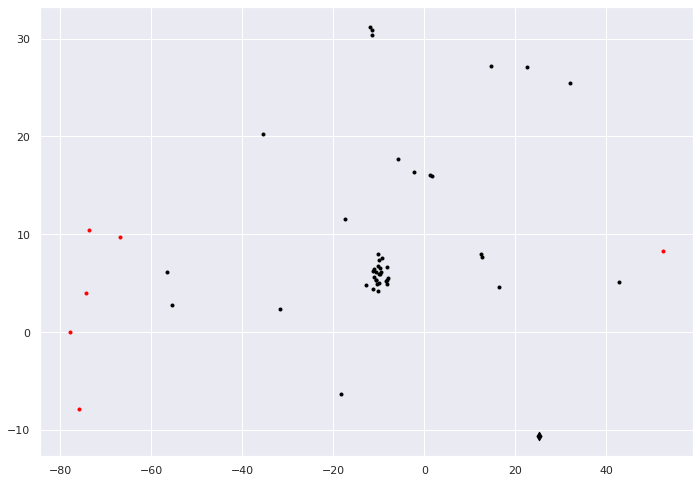

-------------------
Agrobacterium
6 Agrobacterium
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


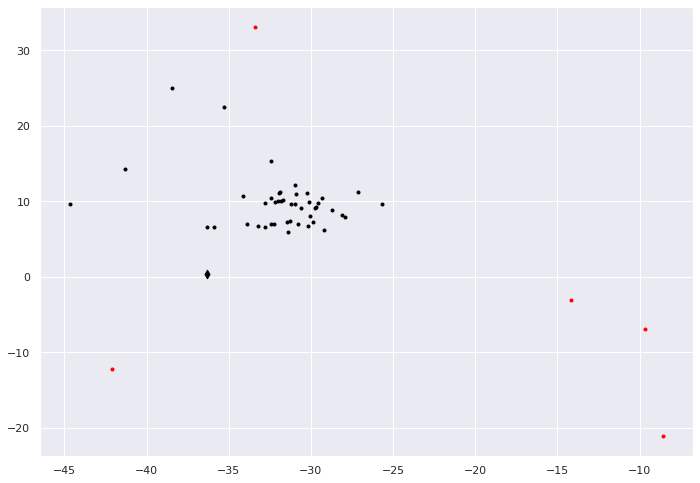

-------------------
Anabaena
7 Anabaena
Adjusted Rand Index: -0.07976293369551797
fowlkes_mallows_score: 0.8152190738955344
homogeneity_completeness_v_measure: 0.034412660271568175 0.026049018028360408 0.02965236933619754


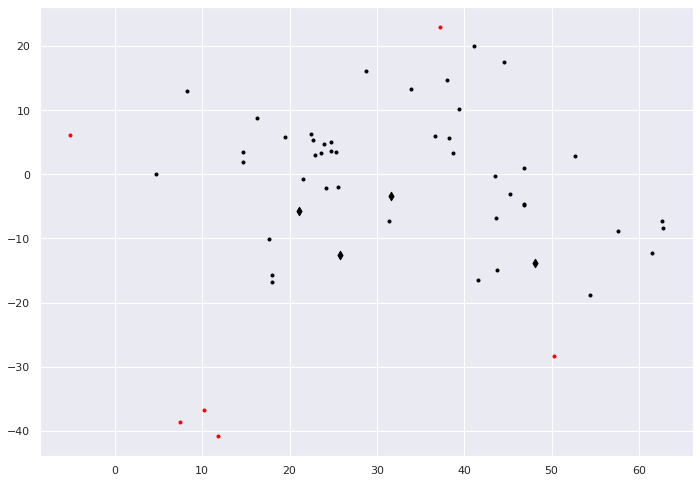

-------------------
Arthrobacter
9 Arthrobacter
Adjusted Rand Index: -0.0375148760584774
fowlkes_mallows_score: 0.8734940058566528
homogeneity_completeness_v_measure: 0.023985218397299682 0.0086615974396757 0.012727140514868713


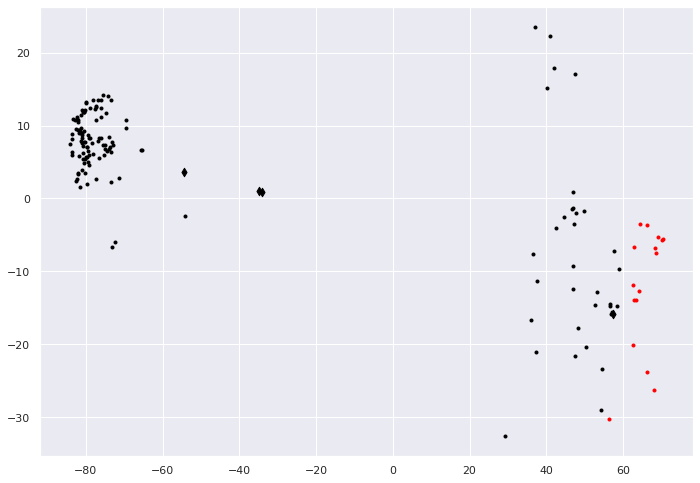

-------------------
Arthrospira
10 Arthrospira
Adjusted Rand Index: -0.030688622754491017
fowlkes_mallows_score: 0.8838403212710657
homogeneity_completeness_v_measure: 0.021183606185823278 0.006373772059346194 0.009799152591525005


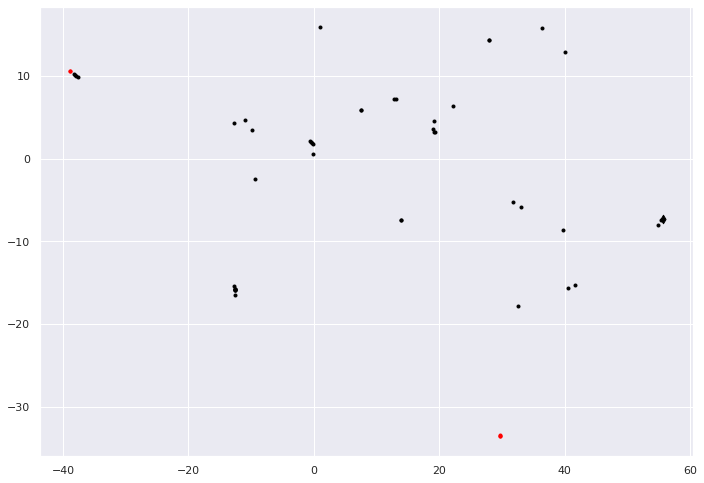

-------------------
Bacillus
11 Bacillus
Adjusted Rand Index: -0.08649151000683811
fowlkes_mallows_score: 0.7981811447351636
homogeneity_completeness_v_measure: 0.035464984163256656 0.036393366238560786 0.03592317803236167


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f75d4f8ef70> (for post_execute):


KeyboardInterrupt: ignored

In [120]:
from sklearn.covariance import EllipticEnvelope


# add grid search to nu


# params for dbscan
values = []
familyes = sorted(set(family_lables))
print(familyes)
for i in familyes:    
  df1= df.query('y==@i')
  df_data1 = df_data.query('family_lable==@i')
  true_labels = df_data1.is_RE.tolist()
# print(len(familyes))
  # values.append({'n_clusters':2})
clustering_function(familyes,df_data, df, EllipticEnvelope, params=None)




In [126]:
import pandas as pd

a = pd.DataFrame(all_res_table)
len(a.family_lable.unique())
a

,algo,family_lable,ari,fmi,homogeneity,completeness,v_measure,tp,fp,fn,tn
0,<class 'sklearn.cluster._dbscan.DBSCAN'>,Aeropyrum,-0.028976,0.920937,0.012443,0.005368,0.007500,0.000000,0.000000,0.000000,0.000000
1,<class 'sklearn.cluster._dbscan.DBSCAN'>,Agmenellum,-0.004363,0.685761,0.131019,0.018288,0.032096,0.000182,0.000182,0.000182,0.000182
2,<class 'sklearn.cluster._dbscan.DBSCAN'>,Agrobacterium,-0.028976,0.920937,0.012443,0.005368,0.007500,0.000000,0.000000,0.000000,0.000000
3,<class 'sklearn.cluster._dbscan.DBSCAN'>,Anabaena,-0.010273,0.524362,0.096466,0.023384,0.037643,0.000000,0.000000,0.000000,0.000000
4,<class 'sklearn.cluster._dbscan.DBSCAN'>,Arthrobacter,0.082161,0.715154,0.518517,0.071001,0.124899,0.000182,0.000182,0.000182,0.000182
5,<class 'sklearn.ensemble._iforest.IsolationFor...,Aeropyrum,-0.030424,0.848967,0.030317,0.007316,0.011787,0.000000,0.000000,0.000000,0.000000
6,<class 'sklearn.ensemble._iforest.IsolationFor...,Agmenellum,0.046069,0.747958,0.240004,0.037236,0.064470,0.000182,0.000182,0.000182,0.000182
7,<class 'sklearn.ensemble._iforest.IsolationFor...,Agrobacterium,0.116499,0.831568,0.339525,0.066207,0.110807,0.000182,0.000182,0.000182,0.000182
8,<class 'sklearn.ensemble._iforest.IsolationFor...,Anabaena,-0.065749,0.682540,0.103232,0.044856,0.062538,0.000000,0.000000,0.000000,0.000000
9,<class 'sklearn.ensemble._iforest.IsolationFor...,Arthrobacter,0.046426,0.757514,0.099278,0.019795,0.033009,0.000182,0.000182,0.000182,0.000182
